## Verification of the partial coherence phase screens

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.integrate import simps

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


I am simulating a Gaussian Schell model beam using a technique described in [Xiao and Voelz, "Wave optics simulation approach for partial spatially coherent beams," Opt. Express 14, 6986-6992 (2006)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986) and Chapter 9 of [Computational Fourier Optics: A MATLAB Tutorial](http://spie.org/Publications/Book/858456), which is also by Voelz. This workbook verifies that we can produce the same results for the partial spatial coherence simulation as presented on page 186 of Voelz's book. 

## Build the coordinate system

In [2]:
focalLength = .25

wavelength  = 650e-9

gridSize     = 251 # Number of grid (or lattice) sites for a single lenslet
physicalSize = 50e-3 # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.Grid(gridSize, physicalSize, wavelength, focalLength, dim = 1)

The desired coherence length is set in `coherenceLength`. The rest of the beam is defined as described in another notebook.

In [3]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 1e-3
coherenceLength = 8e-3
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

beam     = fields.GSMBeamRealization(fieldAmp, beamStd, coherenceLength, grid)

Let's go ahead and plot one realization of the phase angle generated from this beam. We won't use the Gaussian envelope; only the phase.

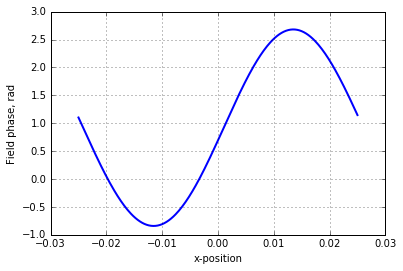

In [4]:
beamSample = beam(grid.px)

plt.plot(grid.px, np.angle(beamSample), linewidth = 2)
plt.xlabel(r'x-position')
plt.ylabel(r'Field phase, rad')
plt.grid(True)
plt.show()

## Computing the two-slit diffraction pattern
First, let's define the field. We have a plane wave incident on two slits symmetrically placed about the origin.

In [5]:
slitWidth  = 2e-3 
slitOffset = 2.5e-3
beamPower  = 100  # mW

Z0    = 376.73 # Impedance of free space, Ohms
amp   = np.sqrt((beamPower / 1000) * Z0 / slitWidth / 2)
field = np.zeros(grid.px.size)
field[np.logical_and(grid.px >  (-slitOffset - slitWidth / 2), grid.px <= (-slitOffset + slitWidth / 2))] = amp
field[np.logical_and(grid.px >= ( slitOffset - slitWidth / 2), grid.px <  ( slitOffset + slitWidth / 2))] = amp

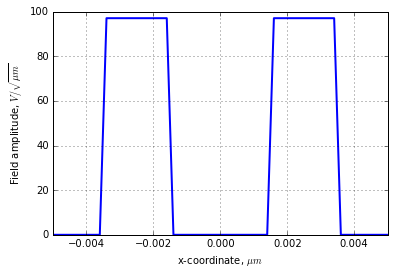

In [6]:
plt.plot(grid.px, field, linewidth = 2)
plt.xlim((-5e-3, 5e-3))
plt.xlabel(r'x-coordinate, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.grid(True)
plt.show()

Next, let's compute the diffraction pattern from this field distribution.

In [7]:
dx = grid.px[1] - grid.px[0]
F  = fftshift(fft(ifftshift(field))) * dx
Irrad = np.abs(F)**2 / wavelength / focalLength

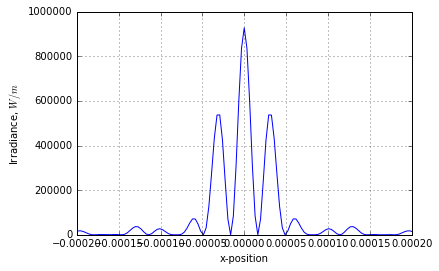

In [8]:
plt.plot(grid.pX, Irrad)
plt.xlim((-2e-4,2e-4))
plt.xlabel('x-position')
plt.ylabel('Irradiance, $W / m$')
plt.grid(True)
plt.show()

In [9]:
# Check power conservation
intPower = simps(Irrad, grid.pX)
print(intPower / Z0 * 1000) 

100.399980538


## Add partial spatial coherence to the incident beam.
Now that we have a two slit interferometer to experiment with, we can begin adjust the spatial coherence of the beam.

Let's first start by computing the random realization of the phase screen and apply it to the incident field.

In [10]:
# Generate a new phase screen
beamSample = beam(grid.px)

t = np.exp(1j * np.angle(beamSample))
newField = t * field

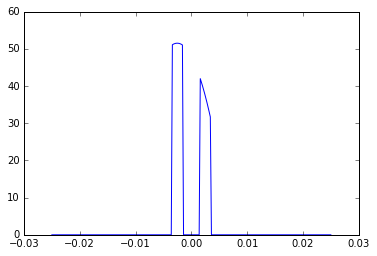

In [11]:
plt.plot(grid.px, np.real(newField))
plt.show()

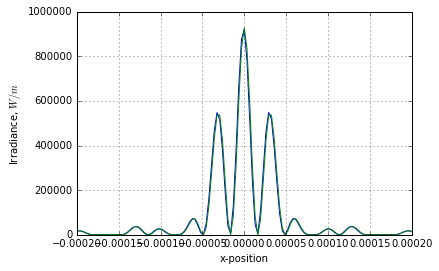

In [12]:
# Propagate and plot the new field
dx = grid.px[1] - grid.px[0]
F  = fftshift(fft(ifftshift(newField))) * dx
newIrrad = np.abs(F)**2 / wavelength / focalLength

plt.plot(grid.pX, newIrrad)
plt.plot(grid.pX, Irrad)
plt.xlim((-2e-4,2e-4))
plt.xlabel('x-position')
plt.ylabel('Irradiance, $W / m$')
plt.grid(True)
plt.show()

## Compute the averaged irradiance for multiple realizations

In [13]:
nIter = 1000
dx = grid.px[1] - grid.px[0]

finalIrrad = np.zeros(grid.px.size)
for ctr in range(nIter):
    # Create a new realization of the field
    t = np.exp(1j * np.angle(beam(grid.px)))
    newField = t * field
    
    F  = fft(ifftshift(newField)) * dx
    Irrad = np.abs(F)**2 / wavelength / focalLength
    
    finalIrrad = finalIrrad + Irrad
    
# Find the averaged irradiance pattern    
finalIrrad = fftshift(finalIrrad) / nIter

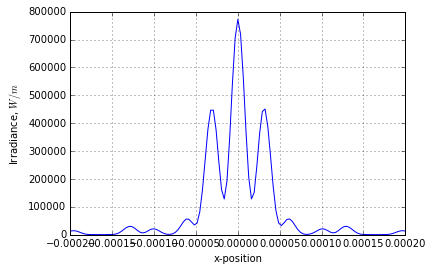

In [14]:
plt.plot(grid.pX, finalIrrad)
plt.xlim((-2e-4,2e-4))
plt.xlabel('x-position')
plt.ylabel('Irradiance, $W / m$')
plt.grid(True)
plt.show()

In [15]:
# Check the integrated power
intPower = simps(newIrrad, grid.pX)
print(intPower / Z0 * 1000)

100.399897761


## Compute the degree of coherence from this profile
The degree of coherence may be obtained by fitting the analytical results to this irradiance profile for \\( \left| \mu_{12} \right| \\):

$$ I \left( x' \right) = \frac{2 a^2 E_0^2}{\lambda f} \text{sinc}^2 \left( \frac{a x'}{\lambda z} \right) \times \left[ 1 + \left| \mu_{12} \right| \cos \left( 2 \pi \frac{\Delta s}{\lambda f} x' \right) \right] $$

Where \\( a \\) is the width of a single slit, \\( E_0 \\) is the field amplitude, \\( \Delta s \\) is the separation between the two slits, and \\( \text{sinc} \left( x \right) = \frac{\sin \pi x}{\pi x} \\). The analytical result only holds when the coherence length is on the order of or larger than the beam diameters.

In [16]:
from scipy.optimize import curve_fit as cf

def sinc(x):
    if (x != 0):
        # Prevent divide-by-zero
        return np.sin(np.pi * x) / (np. pi * x)
    else:
        return 1
sinc = np.vectorize(sinc)

def theory(x, *p):
    mu = p
    
    return 2 * slitWidth**2 * amp**2 / wavelength / focalLength * sinc(x * slitWidth / wavelength / focalLength)**2 \
        * (1 + mu * np.cos(2 * np.pi * (slitOffset * 2) * x / wavelength / focalLength))

In [17]:
initGuess = 0.6
popt, _ = cf(theory, grid.pX, finalIrrad, p0 = initGuess)

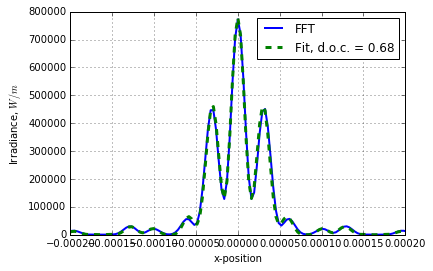

The fitted coherence length is: 0.0080
The input coherence length is: 0.0080


In [18]:
mu = popt[0]

plt.plot(grid.pX, finalIrrad, linewidth = 2, label = 'FFT')
plt.plot(grid.pX, theory(grid.pX, mu), '--', linewidth = 3, label = 'Fit, d.o.c. = {0:.2f}'.format(mu))
plt.xlim((-2e-4,2e-4))
plt.xlabel('x-position')
plt.ylabel('Irradiance, $W / m$')
plt.grid(True)
plt.legend()
plt.show()


numericCohLength = np.sqrt(- (2 * slitOffset)**2 / np.log(mu))
print('The fitted coherence length is: {0:.4f}'.format(numericCohLength))
print('The input coherence length is: {0:.4f}'.format(coherenceLength))